In [1]:
import numpy as np
import torch


import json
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch import nn


from statistics import mean

In [2]:
import utils_generic as generic
import rrnn_modelo as rrnn
import model_confs as confs


import train

from gensim.models import KeyedVectors

c:\Users\kuina\anaconda3\envs\tfg\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

word2vec_path = r"C:\Users\kuina\gensim-data\word2vec-google-news-300\word2vec-google-news-300.gz"
word2vec_model =  KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Datos ConvAI2

In [4]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [5]:
convai_train = data['train']
convai_val = data['validation']


vocabulary = set(generic.create_word_to_index(convai_train).keys()) & set(word2vec_model.key_to_index.keys())
word_to_index = {}
emb_weights = []
for new_id, word in zip(range(len(vocabulary)),vocabulary):
    word_to_index[word] = new_id
    emb_weights.append(word2vec_model[word])

emb_weights = np.array(emb_weights)



In [6]:
convai_train_token = generic.tokenize_dataset_rrnn(convai_train,['about','to','as'],word_to_index) 
convai_val_token = generic.tokenize_dataset_rrnn(convai_val,['about','to','as'],word_to_index) 

In [7]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] =rrnn.DatasetSingleTaskRRNN(convai_train_token,task,eval=False)

In [8]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = rrnn.DatasetSingleTaskRRNN(convai_val_token,task,eval=False)

# Datos md_gender

In [9]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [10]:
md_tokenized = generic.tokenize_dataset_rrnn(md_data,['about','to','as'],word_to_index) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = rrnn.DatasetSingleTaskRRNN(md_tokenized,task,eval=True)

# Creación dataloaders

In [11]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [12]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=rrnn.collate_fn)

In [13]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=rrnn.collate_fn)

# Hiperparámetros

In [14]:
emb_dim = 20
vocab_size = len(vocabulary)
num_labels = 2
lstm_hidden_dim = 128

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6977078232407985 	 Validation loss: 0.6940682540505619 	 
  1%|          | 574/57400 [00:03<04:49, 196.04it/s]
Epoch 2 	 Training loss: 0.6912335555104844 	 Validation loss: 0.6891662680496604 	 
  2%|▏         | 1148/57400 [00:06<04:48, 195.27it/s]
Epoch 3 	 Training loss: 0.6864815944163226 	 Validation loss: 0.6858823238793066 	 
  3%|▎         | 1722/57400 [00:09<04:45, 195.12it/s]
Epoch 4 	 Training loss: 0.6833983663897897 	 Validation loss: 0.6844298869876538 	 
  4%|▍         | 2296/57400 [00:12<04:43, 194.29it/s]
Epoch 5 	 Training loss: 0.6818549165742323 	 Validation loss: 0.6838405970799721 	 
  5%|▌         | 2870/57400 [00:15<04:32, 200.02it/s]
Epoch 6 	 Training loss: 0.6812616417424604 	 Validation loss: 0.6835956866458311 	 
  6%|▌         | 3444/57400 [00:19<04:29, 199.95it/s]
Epoch 7 	 Training loss: 0.6809457565433887 	 Validation loss: 0.6832762885901887 	 
  7%|▋         | 4018/57400 [00:22<04:37, 192.37it/s]
Epoch 8 	 Training loss: 0.6

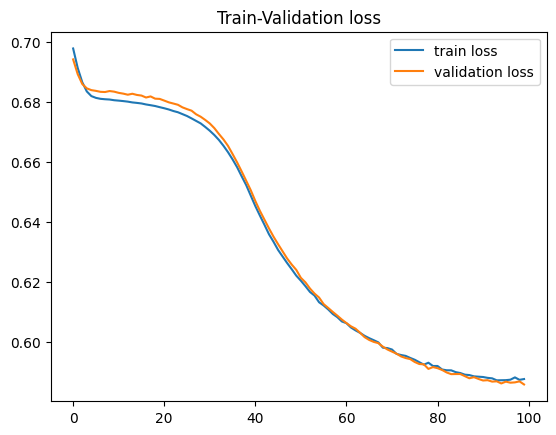

In [16]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_about_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [17]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5306122448979592, 'precision': 0.5306122448979592, 'f1': 0.5306122448979592, 'accuracy': 0.5306122448979592}
MALE {'recall': 0.9348958333333334, 'precision': 0.9348958333333334, 'f1': 0.9348958333333335, 'accuracy': 0.9348958333333334}
FEMALE {'recall': 0.1425, 'precision': 0.1425, 'f1': 0.1425, 'accuracy': 0.1425} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5492424242424242, 'precision': 0.5492424242424242, 'f1': 0.5492424242424242, 'accuracy': 0.5492424242424242}
MALE {'recall': 0.9172749391727494, 'precision': 0.9172749391727494, 'f1': 0.9172749391727494, 'accuracy': 0.9172749391727494}
FEMALE {'recall': 0.15223097112860892, 'precision': 0.15223097112860892, 'f1': 0.15223097112860892, 'accuracy': 0.15223097112860892} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5280312907431551, 'precision': 0.5280312907431551, 'f1': 0.5280312907431551, 'accuracy': 0.5280312907431551}
MALE {'recal

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6963135321796563 	 Validation loss: 0.693322223121837 	 
  1%|          | 574/57400 [00:03<04:52, 194.02it/s]
Epoch 2 	 Training loss: 0.6908572881063934 	 Validation loss: 0.6891765513662564 	 
  2%|▏         | 1148/57400 [00:06<04:49, 194.53it/s]
Epoch 3 	 Training loss: 0.6866405183637599 	 Validation loss: 0.6861933368747517 	 
  3%|▎         | 1722/57400 [00:09<04:39, 199.30it/s]
Epoch 4 	 Training loss: 0.6838028881607986 	 Validation loss: 0.6844316761372453 	 
  4%|▍         | 2296/57400 [00:12<04:38, 197.83it/s]
Epoch 5 	 Training loss: 0.6821479431843508 	 Validation loss: 0.6838531029426446 	 
  5%|▌         | 2870/57400 [00:15<04:31, 200.87it/s]
Epoch 6 	 Training loss: 0.6814430448444048 	 Validation loss: 0.6836076095952826 	 
  6%|▌         | 3444/57400 [00:18<04:30, 199.58it/s]
Epoch 7 	 Training loss: 0.6811224264757973 	 Validation loss: 0.6836727817179793 	 

1 epoch without improvement
  7%|▋         | 4018/57400 [00:21<04:24, 201.52it/s]


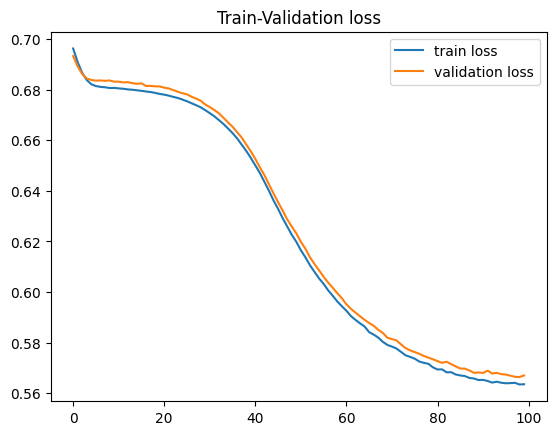

In [18]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_about_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [19]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5369897959183674, 'precision': 0.5369897959183674, 'f1': 0.5369897959183674, 'accuracy': 0.5369897959183674}
MALE {'recall': 0.9166666666666666, 'precision': 0.9166666666666666, 'f1': 0.9166666666666666, 'accuracy': 0.9166666666666666}
FEMALE {'recall': 0.1725, 'precision': 0.1725, 'f1': 0.1725, 'accuracy': 0.1725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5429292929292929, 'precision': 0.5429292929292929, 'f1': 0.5429292929292929, 'accuracy': 0.5429292929292929}
MALE {'recall': 0.8978102189781022, 'precision': 0.8978102189781022, 'f1': 0.8978102189781021, 'accuracy': 0.8978102189781022}
FEMALE {'recall': 0.16010498687664043, 'precision': 0.16010498687664043, 'f1': 0.16010498687664043, 'accuracy': 0.16010498687664043} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.5371577574967406, 'precision': 0.5371577574967406, 'f1': 0.5371577574967406, 'accuracy': 0.5371577574967406}
MALE {'recal

In [20]:
del model
torch.cuda.empty_cache()

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6916526059655778 	 Validation loss: 0.6896978838969086 	 
  1%|          | 574/57400 [00:03<04:52, 194.39it/s]
Epoch 2 	 Training loss: 0.6871463154874197 	 Validation loss: 0.6865917666483734 	 
  2%|▏         | 1148/57400 [00:06<04:53, 191.39it/s]
Epoch 3 	 Training loss: 0.6842388440092266 	 Validation loss: 0.6849075747748553 	 
  3%|▎         | 1722/57400 [00:09<04:49, 192.00it/s]
Epoch 4 	 Training loss: 0.6824569162176046 	 Validation loss: 0.6840702669095184 	 
  4%|▍         | 2296/57400 [00:12<04:32, 202.38it/s]
Epoch 5 	 Training loss: 0.6816676579909042 	 Validation loss: 0.683771755735753 	 
  5%|▌         | 2870/57400 [00:15<04:39, 195.05it/s]
Epoch 6 	 Training loss: 0.6812862199357993 	 Validation loss: 0.6837355070194956 	 
  6%|▌         | 3444/57400 [00:18<04:35, 195.97it/s]
Epoch 7 	 Training loss: 0.6810798639827489 	 Validation loss: 0.6837002675412065 	 
  7%|▋         | 4018/57400 [00:22<04:29, 198.40it/s]
Epoch 8 	 Training loss: 0.68

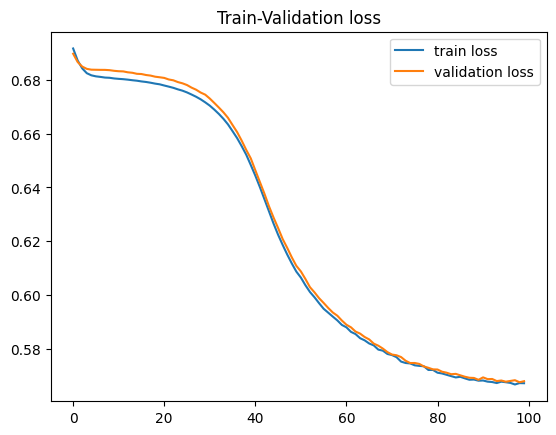

In [21]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_about_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)

In [22]:
del model
torch.cuda.empty_cache()

In [23]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5408163265306123, 'precision': 0.5408163265306123, 'f1': 0.5408163265306123, 'accuracy': 0.5408163265306123}
MALE {'recall': 0.9270833333333334, 'precision': 0.9270833333333334, 'f1': 0.9270833333333334, 'accuracy': 0.9270833333333334}
FEMALE {'recall': 0.17, 'precision': 0.17, 'f1': 0.17, 'accuracy': 0.17} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.5366161616161617, 'precision': 0.5366161616161617, 'f1': 0.5366161616161617, 'accuracy': 0.5366161616161617}
MALE {'recall': 0.9075425790754258, 'precision': 0.9075425790754258, 'f1': 0.9075425790754258, 'accuracy': 0.9075425790754258}
FEMALE {'recall': 0.13648293963254593, 'precision': 0.13648293963254593, 'f1': 0.13648293963254593, 'accuracy': 0.13648293963254593} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.529335071707953, 'precision': 0.529335071707953, 'f1': 0.529335071707953, 'accuracy': 0.529335071707953}
MALE {'recall': 0.848484

In [24]:
del model
torch.cuda.empty_cache()

In [25]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5361394557823129, 'precision': 0.5361394557823129, 'f1': 0.5361394557823129, 'accuracy': 0.5361394557823129}
Métricas etiqueta male: {'recall': 0.9262152777777778, 'precision': 0.9262152777777778, 'f1': 0.9262152777777778, 'accuracy': 0.9262152777777778}
Métricas etiqueta female:  {'recall': 0.16166666666666665, 'precision': 0.16166666666666665, 'f1': 0.16166666666666665, 'accuracy': 0.16166666666666665}

 to
Resultado global: {'recall': 0.5429292929292929, 'precision': 0.5429292929292929, 'f1': 0.5429292929292929, 'accuracy': 0.5429292929292929}
Métricas etiqueta male: {'recall': 0.9075425790754258, 'precision': 0.9075425790754258, 'f1': 0.9075425790754258, 'accuracy': 0.9075425790754258}
Métricas etiqueta female:  {'recall': 0.14960629921259844, 'precision': 0.14960629921259844, 'f1': 0.14960629921259844, 'accuracy': 0.14960629921259844}

 as
Resultado global: {'recall': 0.5315080399826162, 'precision': 0.5315080399826162, '

# TO

In [26]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6936759957037736 	 Validation loss: 0.6923788583884805 	 
  1%|          | 574/57400 [00:03<05:36, 168.88it/s]
Epoch 2 	 Training loss: 0.6934533037167393 	 Validation loss: 0.692445378182298 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:07<05:33, 168.67it/s]
Epoch 3 	 Training loss: 0.6931549785236863 	 Validation loss: 0.6926685753515212 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:11<05:41, 162.99it/s]
Epoch 4 	 Training loss: 0.6931770857202882 	 Validation loss: 0.6927704316074565 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:15<05:33, 165.26it/s]
Epoch 5 	 Training loss: 0.6931354561333872 	 Validation loss: 0.69278870901819 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:18<05:24, 167.87it/s]
Epoch 6 	 Training loss: 0.6931659937527952 	 Validation loss: 0.6927213537490974 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:22<05:36, 160.38it/s]
Epoch 7 	 Training loss: 

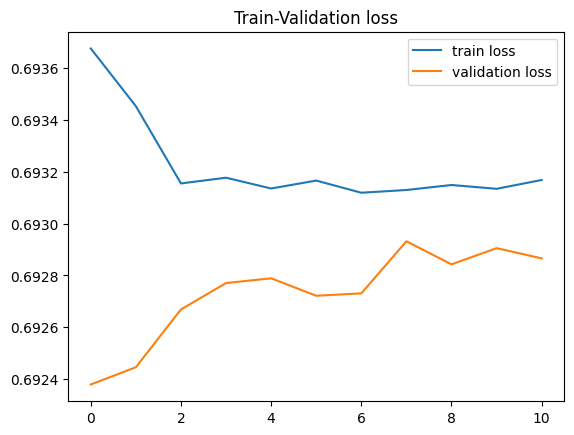

In [27]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_to_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [28]:
del model
torch.cuda.empty_cache()

In [29]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6940124294483703 	 Validation loss: 0.6917548846390288 	 
  1%|          | 574/57400 [00:03<05:40, 166.80it/s]
Epoch 2 	 Training loss: 0.6935719509157985 	 Validation loss: 0.6920878978098853 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [00:07<05:55, 158.45it/s]
Epoch 3 	 Training loss: 0.6932432495758508 	 Validation loss: 0.6925685254193968 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [00:11<05:34, 166.56it/s]
Epoch 4 	 Training loss: 0.6932280794668696 	 Validation loss: 0.6924803772215116 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [00:14<05:27, 168.25it/s]
Epoch 5 	 Training loss: 0.6931261642469346 	 Validation loss: 0.6926943972959356 	 

4 epoch without improvement
  5%|▌         | 2870/57400 [00:18<05:25, 167.27it/s]
Epoch 6 	 Training loss: 0.6932200667957811 	 Validation loss: 0.6930430167812413 	 

5 epoch without improvement
  6%|▌         | 3444/57400 [00:22<05:20, 168.13it/s]
Epoch 7 	 Training los

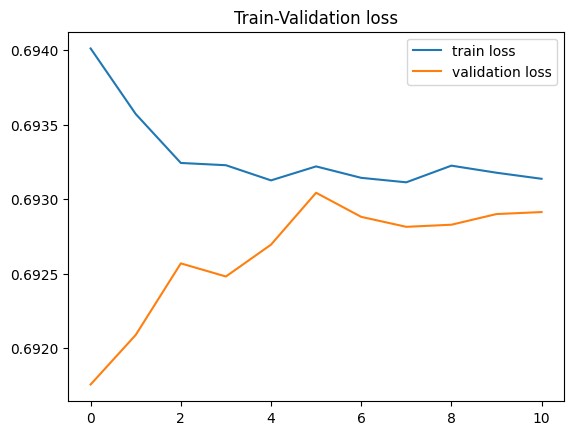

In [30]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_to_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [31]:
del model
torch.cuda.empty_cache()

In [32]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5102040816326531, 'precision': 0.5102040816326531, 'f1': 0.5102040816326531, 'accuracy': 0.5102040816326531}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4810606060606061, 'precision': 0.4810606060606061, 'f1': 0.4810606060606061, 'accuracy': 0.4810606060606061}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}
MALE {'recall': 0.0, 'precision': 0.0, 'f1': 0.0, 'accuracy': 0.0}
FEMALE {'recall': 1.0, 'precision': 1.0, 'f1': 1.0, 'accuracy': 1.0} 



In [33]:
del model
torch.cuda.empty_cache()

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6943263621280418 	 Validation loss: 0.6950846920579167 	 
  1%|          | 574/57400 [00:03<05:36, 169.05it/s]
Epoch 2 	 Training loss: 0.6935610640339736 	 Validation loss: 0.694218854782945 	 
  2%|▏         | 1148/57400 [00:07<05:26, 172.53it/s]
Epoch 3 	 Training loss: 0.6933571890463812 	 Validation loss: 0.6939907518483824 	 
  3%|▎         | 1722/57400 [00:10<05:24, 171.47it/s]
Epoch 4 	 Training loss: 0.693281375884179 	 Validation loss: 0.6937188637458672 	 
  4%|▍         | 2296/57400 [00:14<05:15, 174.78it/s]
Epoch 5 	 Training loss: 0.6932407529304252 	 Validation loss: 0.6933724364991916 	 
  5%|▌         | 2870/57400 [00:17<05:10, 175.37it/s]
Epoch 6 	 Training loss: 0.6932374446649585 	 Validation loss: 0.6930970317226345 	 
  6%|▌         | 3444/57400 [00:21<05:15, 171.28it/s]
Epoch 7 	 Training loss: 0.6932288017837843 	 Validation loss: 0.6930572723938246 	 
  7%|▋         | 4018/57400 [00:25<05:09, 172.48it/s]
Epoch 8 	 Training loss: 0.693

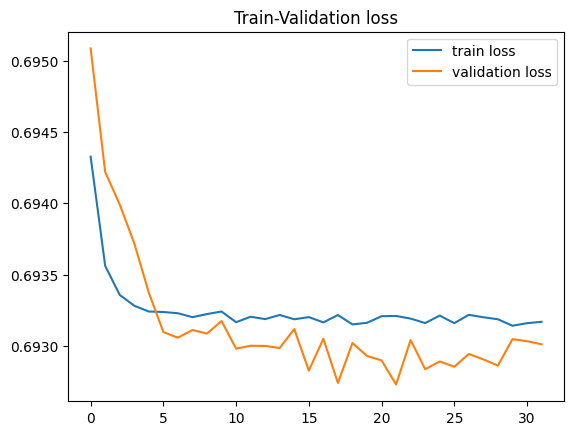

In [34]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_to_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)

In [35]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5076530612244898, 'precision': 0.5076530612244898, 'f1': 0.5076530612244898, 'accuracy': 0.5076530612244898}
MALE {'recall': 0.036458333333333336, 'precision': 0.036458333333333336, 'f1': 0.036458333333333336, 'accuracy': 0.036458333333333336}
FEMALE {'recall': 0.96, 'precision': 0.96, 'f1': 0.96, 'accuracy': 0.96} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.47474747474747475, 'precision': 0.47474747474747475, 'f1': 0.47474747474747475, 'accuracy': 0.47474747474747475}
MALE {'recall': 0.031630170316301706, 'precision': 0.031630170316301706, 'f1': 0.031630170316301706, 'accuracy': 0.031630170316301706}
FEMALE {'recall': 0.952755905511811, 'precision': 0.952755905511811, 'f1': 0.952755905511811, 'accuracy': 0.952755905511811} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.47327249022164275, 'precision': 0.47327249022164275, 'f1': 0.47327249022164275, 'accuracy': 0.47327249022164275}
MALE

In [36]:
del model
torch.cuda.empty_cache()

In [37]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5093537414965986, 'precision': 0.5093537414965986, 'f1': 0.5093537414965986, 'accuracy': 0.5093537414965986}
Métricas etiqueta male: {'recall': 0.012152777777777778, 'precision': 0.012152777777777778, 'f1': 0.012152777777777778, 'accuracy': 0.012152777777777778}
Métricas etiqueta female:  {'recall': 0.9866666666666667, 'precision': 0.9866666666666667, 'f1': 0.9866666666666667, 'accuracy': 0.9866666666666667}

 to
Resultado global: {'recall': 0.47895622895622897, 'precision': 0.47895622895622897, 'f1': 0.47895622895622897, 'accuracy': 0.47895622895622897}
Métricas etiqueta male: {'recall': 0.010543390105433903, 'precision': 0.010543390105433903, 'f1': 0.010543390105433903, 'accuracy': 0.010543390105433903}
Métricas etiqueta female:  {'recall': 0.984251968503937, 'precision': 0.984251968503937, 'f1': 0.984251968503937, 'accuracy': 0.984251968503937}

 as
Resultado global: {'recall': 0.48022598870056493, 'precision': 0.4802259887

# AS

In [39]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'as':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}},
                    'to':{'global':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'male':{'recall': [], 'precision': [],'f1': [], 'accuracy': []},
                            'female':{'recall': [], 'precision': [],'f1': [], 'accuracy': []}}}

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6940086026017259 	 Validation loss: 0.6948361699864015 	 
  1%|          | 574/57400 [00:04<06:46, 139.79it/s]
Epoch 2 	 Training loss: 0.6935503058109549 	 Validation loss: 0.6942209136688103 	 
  2%|▏         | 1148/57400 [00:09<06:42, 139.76it/s]
Epoch 3 	 Training loss: 0.693346763944792 	 Validation loss: 0.6935873546842801 	 
  3%|▎         | 1722/57400 [00:13<05:19, 174.41it/s]
Epoch 4 	 Training loss: 0.6932546792337704 	 Validation loss: 0.6934281324936171 	 
  4%|▍         | 2296/57400 [00:17<05:20, 171.79it/s]
Epoch 5 	 Training loss: 0.6931864809283812 	 Validation loss: 0.6932352488323793 	 
  5%|▌         | 2870/57400 [00:20<05:22, 169.24it/s]
Epoch 6 	 Training loss: 0.6931889718625603 	 Validation loss: 0.6933022101046675 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [00:24<05:10, 173.57it/s]
Epoch 7 	 Training loss: 0.693191151897251 	 Validation loss: 0.6932265051340653 	 
  7%|▋         | 4018/57400 [00:28<05:07, 173.61it/s]
E

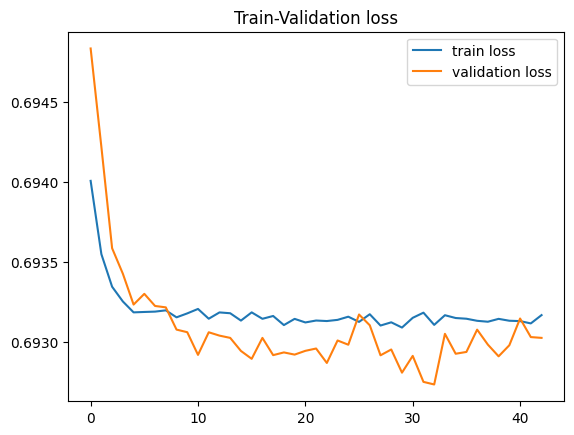

In [40]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_as_1'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [41]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5025510204081632, 'precision': 0.5025510204081632, 'f1': 0.5025510204081632, 'accuracy': 0.5025510204081632}
MALE {'recall': 0.020833333333333332, 'precision': 0.020833333333333332, 'f1': 0.020833333333333332, 'accuracy': 0.020833333333333332}
FEMALE {'recall': 0.965, 'precision': 0.965, 'f1': 0.965, 'accuracy': 0.965} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4772727272727273, 'precision': 0.4772727272727273, 'f1': 0.4772727272727273, 'accuracy': 0.4772727272727273}
MALE {'recall': 0.019464720194647202, 'precision': 0.019464720194647202, 'f1': 0.019464720194647202, 'accuracy': 0.019464720194647202}
FEMALE {'recall': 0.9711286089238845, 'precision': 0.9711286089238845, 'f1': 0.9711286089238845, 'accuracy': 0.9711286089238845} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.4784876140808344, 'precision': 0.4784876140808344, 'f1': 0.4784876140808344, 'accuracy': 0.4784876140808344}
MALE

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6945279507479186 	 Validation loss: 0.6955521470409328 	 
  1%|          | 574/57400 [00:03<05:23, 175.43it/s]
Epoch 2 	 Training loss: 0.6936488192048222 	 Validation loss: 0.6941623617026765 	 
  2%|▏         | 1148/57400 [00:07<05:25, 172.92it/s]
Epoch 3 	 Training loss: 0.6934526756873114 	 Validation loss: 0.6936852406647246 	 
  3%|▎         | 1722/57400 [00:10<05:29, 169.17it/s]
Epoch 4 	 Training loss: 0.6933121832821012 	 Validation loss: 0.6938206401921935 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [00:14<05:26, 168.57it/s]
Epoch 5 	 Training loss: 0.6932305200382393 	 Validation loss: 0.693290664988049 	 
  5%|▌         | 2870/57400 [00:17<05:12, 174.47it/s]
Epoch 6 	 Training loss: 0.6931887074837702 	 Validation loss: 0.6932030481807256 	 
  6%|▌         | 3444/57400 [00:21<05:07, 175.49it/s]
Epoch 7 	 Training loss: 0.6931767608022856 	 Validation loss: 0.6929852800854182 	 
  7%|▋         | 4018/57400 [00:25<05:21, 165.99it/s]


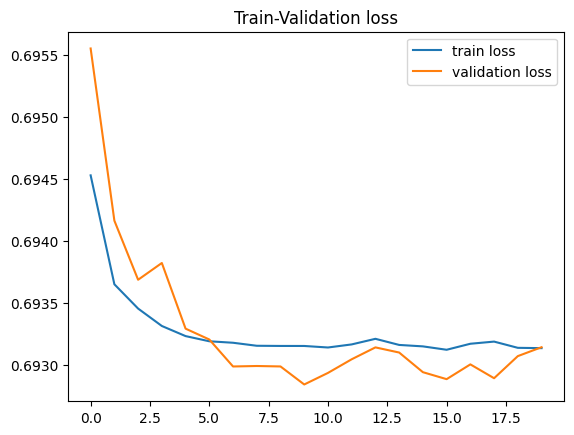

In [42]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_as_2'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [43]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5063775510204082, 'precision': 0.5063775510204082, 'f1': 0.5063775510204082, 'accuracy': 0.5063775510204082}
MALE {'recall': 0.018229166666666668, 'precision': 0.018229166666666668, 'f1': 0.018229166666666668, 'accuracy': 0.018229166666666668}
FEMALE {'recall': 0.975, 'precision': 0.975, 'f1': 0.975, 'accuracy': 0.975} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.476010101010101, 'precision': 0.476010101010101, 'f1': 0.476010101010101, 'accuracy': 0.476010101010101}
MALE {'recall': 0.014598540145985401, 'precision': 0.014598540145985401, 'f1': 0.014598540145985401, 'accuracy': 0.014598540145985401}
FEMALE {'recall': 0.973753280839895, 'precision': 0.973753280839895, 'f1': 0.973753280839895, 'accuracy': 0.973753280839895} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.47979139504563234, 'precision': 0.47979139504563234, 'f1': 0.47979139504563234, 'accuracy': 0.47979139504563234}
MALE {'r

  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.69314271440074 	 Validation loss: 0.6930450645543761 	 
  1%|          | 574/57400 [00:03<05:25, 174.77it/s]
Epoch 2 	 Training loss: 0.6931782453109994 	 Validation loss: 0.6929100337675063 	 
  2%|▏         | 1148/57400 [00:07<05:26, 172.45it/s]
Epoch 3 	 Training loss: 0.6931657855519019 	 Validation loss: 0.6929995771181785 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [00:10<05:24, 171.38it/s]
Epoch 4 	 Training loss: 0.6931230061353292 	 Validation loss: 0.6930327476081202 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [00:14<05:10, 177.51it/s]
Epoch 5 	 Training loss: 0.6931471310633815 	 Validation loss: 0.6929467714439004 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [00:17<05:11, 174.90it/s]
Epoch 6 	 Training loss: 0.6931171884520129 	 Validation loss: 0.6929502749847154 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [00:21<05:02, 178.39it/s]
Epoch 7 	 Training loss: 0.6931267290372882 	 Validat

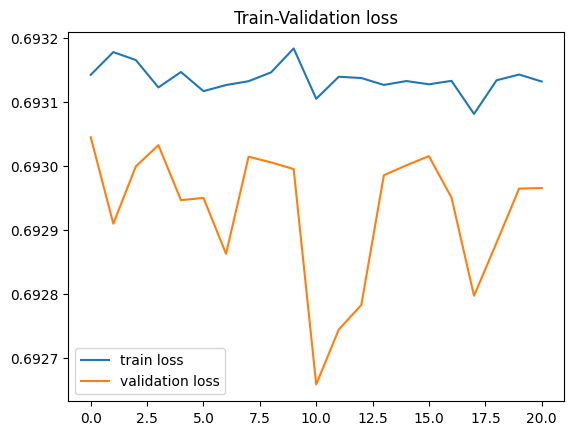

In [44]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)
save_path='m1_w2v_simple_as_3'


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)

In [45]:
model = rrnn.SingleTaskRRNN(vocab_size = vocab_size,emb_dim=emb_dim,lstm_hidden_dim = lstm_hidden_dim,emb_weights=emb_weights).to(device)

model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
   
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = train.eval_func(model,dl_eval[task])
    generic.update_global_metric(metric_result,global_metrics[task]['global'])
    print(f"GLOBAL: {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='male')
    generic.update_global_metric(metric_result,global_metrics[task]['male'])
    print(f"MALE {metric_result}")
    metric_result = train.eval_func(model,dl_eval[task],gender='female')
    generic.update_global_metric(metric_result,global_metrics[task]['female'])
    print(f"FEMALE {metric_result}",'\n')

Evaluación en el conjunto el conjunto about
GLOBAL: {'recall': 0.5127551020408163, 'precision': 0.5127551020408163, 'f1': 0.5127551020408163, 'accuracy': 0.5127551020408163}
MALE {'recall': 0.033854166666666664, 'precision': 0.033854166666666664, 'f1': 0.033854166666666664, 'accuracy': 0.033854166666666664}
FEMALE {'recall': 0.9725, 'precision': 0.9725, 'f1': 0.9725, 'accuracy': 0.9725} 

Evaluación en el conjunto el conjunto to
GLOBAL: {'recall': 0.4936868686868687, 'precision': 0.4936868686868687, 'f1': 0.4936868686868687, 'accuracy': 0.4936868686868687}
MALE {'recall': 0.05596107055961071, 'precision': 0.05596107055961071, 'f1': 0.05596107055961071, 'accuracy': 0.05596107055961071}
FEMALE {'recall': 0.9658792650918635, 'precision': 0.9658792650918635, 'f1': 0.9658792650918635, 'accuracy': 0.9658792650918635} 

Evaluación en el conjunto el conjunto as
GLOBAL: {'recall': 0.48370273794002605, 'precision': 0.48370273794002605, 'f1': 0.48370273794002605, 'accuracy': 0.48370273794002605}


In [46]:

print('Métricas globales: \n')

for task in ['about','to','as']:
    print('\n',task)
    print('Resultado global:',{m:mean(values) for m,values in global_metrics[task]['global'].items()})
    print(f'Métricas etiqueta male:',{m:mean(values) for m,values in global_metrics[task]['male'].items()})
    print('Métricas etiqueta female: ',{m:mean(values) for m,values in global_metrics[task]['female'].items()})


Métricas globales: 


 about
Resultado global: {'recall': 0.5072278911564626, 'precision': 0.5072278911564626, 'f1': 0.5072278911564626, 'accuracy': 0.5072278911564626}
Métricas etiqueta male: {'recall': 0.024305555555555556, 'precision': 0.024305555555555556, 'f1': 0.024305555555555556, 'accuracy': 0.024305555555555556}
Métricas etiqueta female:  {'recall': 0.9708333333333333, 'precision': 0.9708333333333333, 'f1': 0.9708333333333333, 'accuracy': 0.9708333333333333}

 to
Resultado global: {'recall': 0.4823232323232323, 'precision': 0.4823232323232323, 'f1': 0.4823232323232323, 'accuracy': 0.4823232323232323}
Métricas etiqueta male: {'recall': 0.030008110300081103, 'precision': 0.030008110300081103, 'f1': 0.030008110300081103, 'accuracy': 0.030008110300081103}
Métricas etiqueta female:  {'recall': 0.9702537182852143, 'precision': 0.9702537182852143, 'f1': 0.9702537182852143, 'accuracy': 0.9702537182852143}

 as
Resultado global: {'recall': 0.4806605823554976, 'precision': 0.48066058235